### Import some useful pkgs

In [21]:
import os
import sys
import time
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#### Reload my modules

In [22]:
import importlib
import sgm_fns
import utils
importlib.reload(sgm_fns)
importlib.reload(utils);

In [23]:
from spectrome import Brain, path, functions
from sgm_fns import meg_psd2spatialfeature, Sgm
from utils import mag2db

In [24]:
from spectrome import Brain, path, functions
from tqdm import trange, tqdm

import torch
import torch.nn as nn 
import torch.nn.functional as F 
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sklearn.preprocessing import minmax_scale

import numpy as np
import xarray as xr
from easydict import EasyDict as edict
from pathlib import Path
import pickle
import scipy

In [25]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import json

### Some functions

In [26]:
std_psd = lambda x: (x- x.mean(axis=1).reshape(-1, 1))/x.std(axis=1).reshape(-1, 1)
std_vec = lambda x: (x-x.mean())/x.std()
minmax_vec = lambda x: (x-x.min())/(x.max()-x.min())

### Load real data PSD and brain

#### PSD and connectome

In [27]:
# Load data
ind_psd_xr = xr.open_dataarray('../data/individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
freqs = ind_psd_xr["frequencies"].values
ind_conn_xr = xr.open_dataarray('../data/individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values



data_dir = path.get_data_path()

#### data for brain plots

In [28]:
# Get reorder indeix
# dk86.***.txt is the order for the MEG data
# DK68_labelorder.xlsx is the order for the template
dk_brainnet = pd.read_excel(Path(data_dir)/"DK68_labelorder.xlsx")
with open(Path(data_dir)/'dk86atlas_regions_python.txt') as f:
    dk_python = f.readlines()
    
brainnet_order = dk_brainnet["Order in Brainstorm"]
dk_python_renamed = []
brainnet_renamed = []

for i in range(len(dk_python)):
    sp1 = dk_python[i].split('=')
    sp2 = sp1[1].split('_')
    dk_python_renamed.append((sp2[0] + ' ' + sp2[1]).lower().strip())

for i in range(len(brainnet_order)):
    brainnet_renamed.append((brainnet_order[i].replace("'","")).lower())

d = {x: a for a, x in enumerate(dk_python_renamed[0:68])}
orderedind = np.array([d[x] for x in brainnet_renamed])

In [29]:
def reorderU(wU):
    wUreorder = wU.copy()
    wUreorder = wU[orderedind]
    return wUreorder

with open(Path(data_dir)/'BNVtemplate_DK68.txt', "r") as tf:
    DKtmplateRaw = tf.readlines()
DKtmplate = np.array([int(x.strip()) for x in DKtmplateRaw])

def U2BrainVec(wU):
    emVec = np.zeros_like(DKtmplate, dtype=np.float64)
    for idx in range(1, 69):
        emVec[DKtmplate==idx] = wU[idx-1]
    return emVec

### Set up Parameters

In [30]:
paras = edict()
paras.noise_sd = 0.2
paras.num_prior_sps = int(1e5)
paras.path = Path("./main_results_nsf")

paras.robustParas = edict()
paras.robustParas.num_rep = 100
paras.robustParas.noise_sd = 0.2
paras.robustParas.num_prior_sps = int(1e5)
paras.robustParas.path = Path(paras.path/"robust_results")

paras.tuningParas = edict()
paras.tuningParas.noise_sd = 0.2
paras.tuningParas.num_prior_sps = int(1e5)
paras.tuningParas.path = Path(paras.path/"tuning_results")

paras.indSCParas = edict()
paras.indSCParas.noise_sd = 0.2
paras.indSCParas.num_prior_sps = int(1e5)
paras.indSCParas.path = Path(paras.path/"ind_results")

In [31]:
#v_lower = 3.5-1.8
#v_upper = 3.5+1.8
#bnds = ((5.0,30.0), (5.0,200.0), (0.1,1.0), (v_lower,v_upper), (0.5,10.0), (0.5,10.0), (5.0,30.0))
#This is the order for the above bounds:  tau_e, tau_i, alpha, speed, gei, gii, tauC,

# taue, taui, tauC, speed, alpha, gii, gei
par_low = np.asarray([0.005,0.005,0.005,1.7,0.1,0.5,0.5])
par_high = np.asarray([0.03, 0.20, 0.03,5.3,  1, 10, 10])
plotLimits = np.array([par_low, par_high]).T

In [32]:
# obtain the brain
data_dir = path.get_data_path()
brain = Brain.Brain()
brain.add_connectome(data_dir)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

sgmmodel = Sgm(brain.reducedConnectome, brain.distance_matrix, freqs)

### Compare my way with annealing

####  Load files

In [69]:
fils = list(paras.indSCParas.path.glob("indSC_100000_sd20_*.pkl"))
tmpSortFn = lambda p: int(p.stem.split("_")[-1])
sorted_fils = sorted(fils, key=tmpSortFn)

#### Get the posterior samples

In [71]:
for ixfil in tqdm(sorted_fils[:]):
    print(ixfil)
    with open(ixfil, "rb") as f:
        curRes = pickle.load(f)
        
    ix = tmpSortFn(ixfil)-1
    if ix <= -(10-1):
        continue
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(data_dir) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
        
    sp, raw_sps = meg_psd2spatialfeature(curBrain.reducedConnectome, ind_psd[:, :, ix], freqs, band="alpha")
    stdSp = std_vec(raw_sps.sum(axis=1))
    stdPsd = std_psd(mag2db(ind_psd[:, :, ix])).flatten()
    curX = torch.Tensor(np.concatenate([stdPsd, stdSp]))
    postSps = curRes.posterior.sample((10000, ), x=curX, max_sampling_batch_size=100000)
    
    curRes.postSps = postSps
    with open(ixfil, "wb") as f:
        pickle.dump(curRes, f)

  0%|                                                                                                                                                                                        | 0/36 [00:00<?, ?it/s]

main_results_nsf/ind_results/indSC_100000_sd20_1.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

  3%|████▉                                                                                                                                                                           | 1/36 [00:00<00:32,  1.08it/s]

main_results_nsf/ind_results/indSC_100000_sd20_2.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

  6%|█████████▊                                                                                                                                                                      | 2/36 [00:01<00:24,  1.36it/s]

main_results_nsf/ind_results/indSC_100000_sd20_3.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

  8%|██████████████▋                                                                                                                                                                 | 3/36 [00:15<03:50,  7.00s/it]

main_results_nsf/ind_results/indSC_100000_sd20_4.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 11%|███████████████████▌                                                                                                                                                            | 4/36 [00:16<02:22,  4.47s/it]

main_results_nsf/ind_results/indSC_100000_sd20_5.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 14%|████████████████████████▍                                                                                                                                                       | 5/36 [00:17<01:36,  3.13s/it]

main_results_nsf/ind_results/indSC_100000_sd20_6.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9986 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.
 17%|█████████████████████████████▎                                                                                                                                                  | 6/36 [03:48<36:55, 73.86s/it]

main_results_nsf/ind_results/indSC_100000_sd20_7.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 19%|██████████████████████████████████▏                                                                                                                                             | 7/36 [03:50<24:22, 50.41s/it]

main_results_nsf/ind_results/indSC_100000_sd20_8.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 22%|███████████████████████████████████████                                                                                                                                         | 8/36 [03:51<16:09, 34.63s/it]

main_results_nsf/ind_results/indSC_100000_sd20_9.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 25%|████████████████████████████████████████████                                                                                                                                    | 9/36 [03:52<10:47, 23.98s/it]

main_results_nsf/ind_results/indSC_100000_sd20_10.pkl


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 10000 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.
 25%|███████████████████████████████████████████▎                                                                                                                                 | 9/36 [58:46<2:56:18, 391.80s/it]


KeyboardInterrupt: 

#### Spectral and spatial features estimation

In [46]:
# the estimated spatial feature from MEG
MEGSPs = []
MEGSPRaws = []
for ix in trange(36):
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(data_dir) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
    
    curMEGSP, curMEGSPRaw = meg_psd2spatialfeature(curBrain.reducedConnectome, ind_psd[:, :, ix], freqs)
    MEGSPs.append(curMEGSP)
    MEGSPRaws.append(curMEGSPRaw.sum(axis=1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 49.09it/s]


In [48]:
# the estimated PSD and spatial feature from SGM 
# for each iteration, we have 20 in total 
for ixfil in tqdm(sorted_fils[:]):
    with open(ixfil, "rb") as f:
        curRes = pickle.load(f)
        
    ix = tmpSortFn(ixfil)-1
    
        
    cur_estparas = np.median(curRes.postSps.numpy(), axis=0)
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(data_dir) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
        
    curSgmModel = Sgm(curBrain.reducedConnectome, curBrain.distance_matrix, freqs)
    curPSD, curSPs = curSgmModel.run_local_coupling_forward(cur_estparas)
    curPSD = curPSD[:68, :]
    curPSD = std_psd(mag2db(np.abs(curPSD)))
        
    
    curRes.sgmPSD = curPSD
    curRes.sgmSP = curSPs 
    with open(ixfil, "wb") as f:
        pickle.dump(curRes, f)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:53<00:00,  1.49s/it]


In [52]:
MEGPSD_mean = np.mean([std_psd(mag2db(ind_psd[:, :, ix])).mean(axis=0) for ix in range(36)], axis=0)
sgmPSDs = []
for ix in trange(len(sorted_fils)):
    with open(sorted_fils[ix], "rb") as f:
        curRes = pickle.load(f)
    sgmPSDs.append(curRes.sgmPSD)    
sgmPSD_mean = np.array(sgmPSDs).mean(axis=1).mean(axis=0)
cor = scipy.stats.pearsonr(std_vec(MEGPSD_mean), std_vec(sgmPSD_mean))[0]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:04<00:00,  7.40it/s]


Text(0, 0.5, 'Normalized PSD')

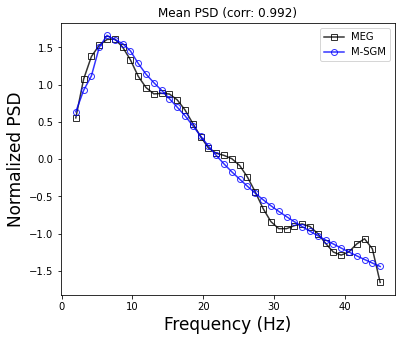

In [55]:
plt.figure(figsize=[6, 5])
plt.title(f"Mean PSD (corr: {cor:.3f})")
plt.plot(freqs, std_vec(MEGPSD_mean), linestyle = '-',marker = 's',fillstyle = 'none',color = 'k', label = "MEG", alpha = 0.8)
plt.plot(freqs, std_vec(sgmPSD_mean), linestyle = '-',marker = 'o',fillstyle = 'none',color = 'b', label = "M-SGM", alpha = 0.8)
plt.xlabel('Frequency (Hz)', fontsize = 17)
plt.legend()
plt.ylabel('Normalized PSD', fontsize = 17)

#### Corrs for PSD and spatial features for each subject

In [57]:
MEG_psd_each_ROIs = np.array([std_psd(mag2db(ind_psd[:, :, ix])) for ix in range(36)])
SGM_psd_ROIs = np.array(sgmPSDs)

PSDCorrs = []
for ix in range(MEG_psd_each_ROIs.shape[0]):
    curMEG = MEG_psd_each_ROIs[ix]
    curSGM = SGM_psd_ROIs[ix]
    PSDCorrs.append(np.mean([scipy.stats.pearsonr(curMEG[iz], curSGM[iz])[0] for iz in range(68)]))

In [62]:
np.mean(PSDCorrs)

0.8705577340875088

In [28]:
np.median(np.array(PSDCorrss), axis=1)

array([0.88021503, 0.88213175, 0.87807268, 0.87511366, 0.88691616,
       0.87407318, 0.87648309, 0.87984351, 0.88376768, 0.87642778,
       0.88247673, 0.88384177, 0.87570285, 0.88136686, 0.88334323,
       0.88282766, 0.87942194, 0.88800771, 0.88292737, 0.88138859,
       0.88548387])

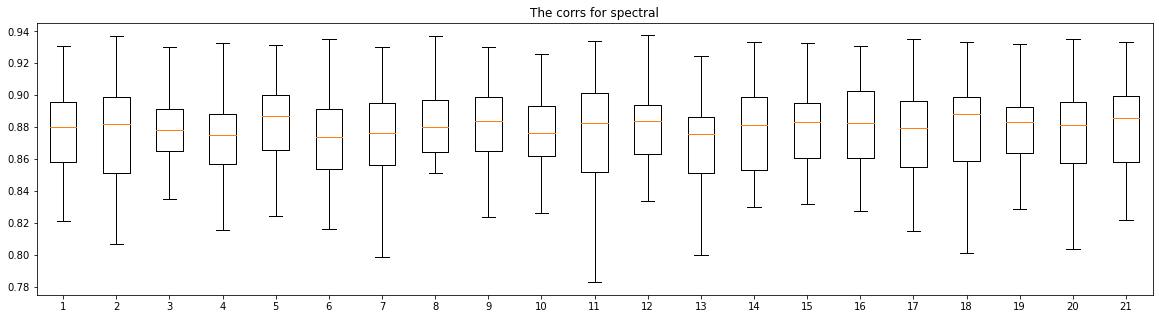

In [354]:
plt.figure(figsize=[20, 5])
plt.title("The corrs for spectral")
_ = plt.boxplot(np.array(PSDCorrss).T, showfliers=False)

In [355]:
SPCorrss = []
for ix in trange(len(sortedFils)):
    with open(sortedFils[ix], "rb") as f:
        curRes = pickle.load(f)
    SPCorrs = []
    for mv, ov in zip(curRes.sgmSPs, MEGSPs):
        SPCorrs.append(np.dot(mv/np.linalg.norm(mv), ov))
        #SPCorrs.append(scipy.stats.pearsonr(mv, ov)[0])
    SPCorrss.append(np.array(SPCorrs))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 37.20it/s]


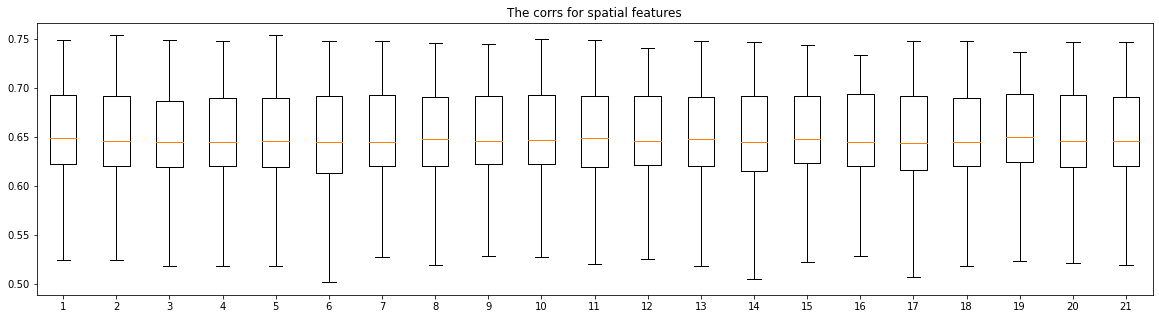

In [356]:
plt.figure(figsize=[20, 5])
plt.title("The corrs for spatial features")
_ = plt.boxplot(np.array(SPCorrss).T, showfliers=False)